In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from data_utils import *
from model_utils import *
import gpytorch
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load data

/tmp/ipykernel_1306343/2100500076.py:33: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


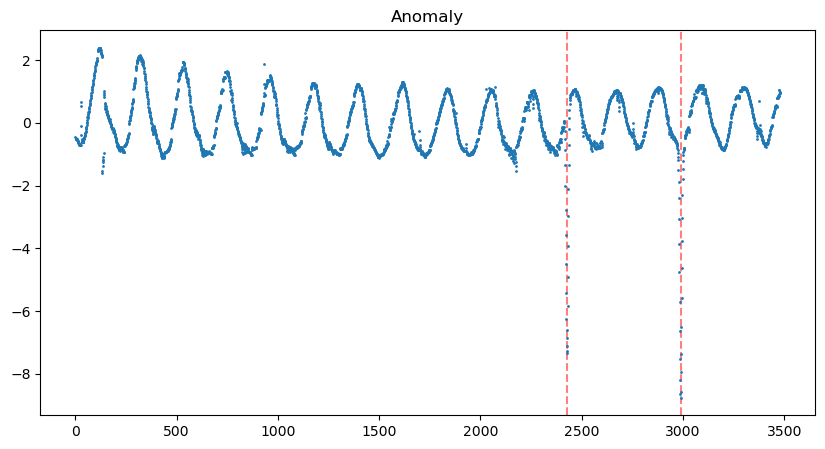

Anomaly locations:
[2987.920761291611, 2426.840741126586]
66.59375
53.697916666666664


In [2]:
# Load a file and inject an anomaly
data_dir = '../data/k2/'
filename = 'k2_72.fits'
fits_file = fits.open(data_dir + filename)

# Load data
data = fits_file[1].data
time = np.array(data['TIME'])
pdc_flux = np.array(data['PDCSAP_FLUX'])
pdc_err = np.array(data['PDCSAP_FLUX_ERR'])

# Set x, y, and error
x = time
y = pdc_flux / np.nanmedian(pdc_flux)
y_err = pdc_err / np.nanmedian(pdc_flux)

# Clean
clean = (y_err > 0.)
x = x[clean]
y = y[clean]
y_err = np.abs(y_err[clean]) 

# Shift to start at time 0
x = x - np.min(x) 

# Bin to 30-minute cadence
num_bins = int(np.floor((np.max(x) - np.min(x)) * 48) + 1) # 48 bins per day
x_bins = np.min(x) + np.arange(num_bins + 1) / 48.
num_binned, bin_edges = np.histogram(x, bins= x_bins)
num_binned = np.array(num_binned)
y_binned, bin_edges = np.histogram(x, bins = x_bins, weights = y)
var_binned, bin_edges = np.histogram(x, bins = x_bins, weights= 1 / y_err**2)
y_err_binned = 1 / np.sqrt(np.array(var_binned))
y_binned = np.array(y_binned)
y_binned = y_binned / (num_binned + 0.001)
x_binned = x_bins[0:num_bins] + (x_bins[1] - x_bins[0]) / 2. 
x = x_binned
y = y_binned
y_err = y_err_binned

# Clean
clean = ((y > 0.) & ~np.isnan(y_err))
x = x[clean]
y = y[clean]
y_err = y_err[clean]

assert len(x) == len(y) == len(y_err), 'Lengths of x, y, and y_err must be the same'

# Inject anomalies
steps, y, anomaly_locs = inject_anomaly(y, num_anomalies=2, seed=42)

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Create original copies of x and y
x_orig = np.copy(x)
y_orig = np.copy(y)
y_err_orig = np.copy(y_err)

# Convert to tensors
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
y_err_tensor = torch.tensor(y_err, dtype=torch.float32).to(device)

# Plot
plt.figure(figsize=(10,5))
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
plt.plot(steps, y, '.', markersize=2)
plt.title("Anomaly")
plt.show()

# Print anomaly_locs, both indices and x[i]
print("Anomaly locations:")
print(anomaly_locs)
for i in anomaly_locs: print(x[int(i)])

# Anomaly detection with GP
### Method:
1. Perform GP regression on the timeseries.
2. Find the most significant outlier point.
3. Exclude that point and redo regression. See if GP improves by some threshold.
4. Exclude adjacent points and redo step 3.
5. Repeat step 4 as long as GP improves the fit by some threshold.
6. If no improvement, define anomaly signal as the difference between data and regression in that interval of points.
7. Repeat steps 2-6 for a defined number of anomalies.

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(




 New dip identified at anomalous index 132, x[index] = 2.864583333333333
Old metric: 1000000.0 - New metric: 0.8437129855155945 = Diff metric: 999999.1875
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 130:134
Old metric: 0.8437129855155945 - New metric: 0.839803159236908 = Diff metric: 0.0039098262786865234
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 128:136
Old metric: 0.839803159236908 - New metric: 0.839583158493042 = Diff metric: 0.0002200007438659668
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 126:138
Old metric: 0.839583158493042 - New metric: 0.835900604724884 = Diff metric: 0.003682553768157959
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 124:140
Old metric: 0.835900604724884 - New metric: 0.8359996676445007 = Diff metric: -9.906291961669922e-05
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 122:142


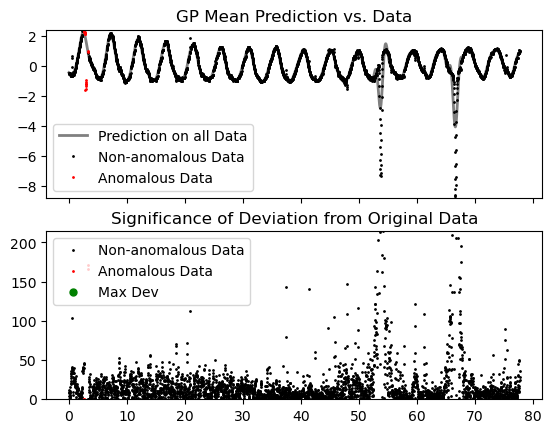



 New dip identified at anomalous index 2968, x[index] = 66.15625
Old metric: 1000000.0 - New metric: 0.8355961441993713 = Diff metric: 999999.1875
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 2966:2970
Old metric: 0.8355961441993713 - New metric: 0.8340290784835815 = Diff metric: 0.001567065715789795
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 2964:2972
Old metric: 0.8340290784835815 - New metric: 0.8320143222808838 = Diff metric: 0.002014756202697754
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 2962:2974
Old metric: 0.8320143222808838 - New metric: 0.8314621448516846 = Diff metric: 0.0005521774291992188
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 2960:2976
Old metric: 0.8314621448516846 - New metric: 0.8243222832679749 = Diff metric: 0.007139861583709717
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 2958:2978
Old metric: 0.8243222832679749 - New metric: 0.8196346163749695 = Diff metric: 0.004687666893005371
Anomaly index 1 x[i] 0.03125, left_edge:right

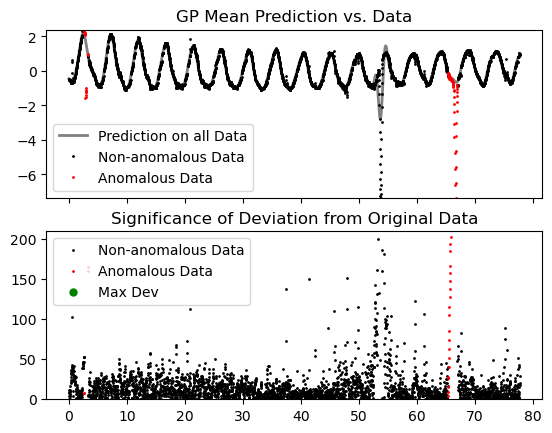



 New dip identified at anomalous index 2407, x[index] = 53.260416666666664
Old metric: 1000000.0 - New metric: 0.7902020215988159 = Diff metric: 999999.1875
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 2405:2409
Old metric: 0.7902020215988159 - New metric: 0.7895249128341675 = Diff metric: 0.0006771087646484375
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 2403:2411
Old metric: 0.7895249128341675 - New metric: 0.7865027785301208 = Diff metric: 0.003022134304046631
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 2401:2413
Old metric: 0.7865027785301208 - New metric: 0.7830693125724792 = Diff metric: 0.0034334659576416016
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 2399:2415
Old metric: 0.7830693125724792 - New metric: 0.777970552444458 = Diff metric: 0.00509876012802124
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 2397:2417
Old metric: 0.777970552444458 - New metric: 0.7713054418563843 = Diff metric

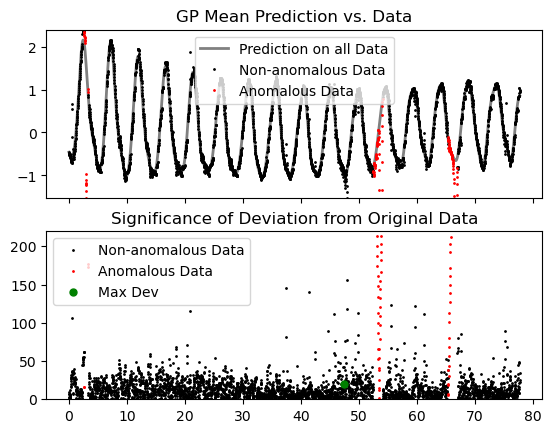



 New dip identified at anomalous index 2155, x[index] = 47.48958333333333
Old metric: 1000000.0 - New metric: 0.7242166996002197 = Diff metric: 999999.25
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 2153:2157
Old metric: 0.7242166996002197 - New metric: 0.7242607474327087 = Diff metric: -4.404783248901367e-05
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 2151:2159


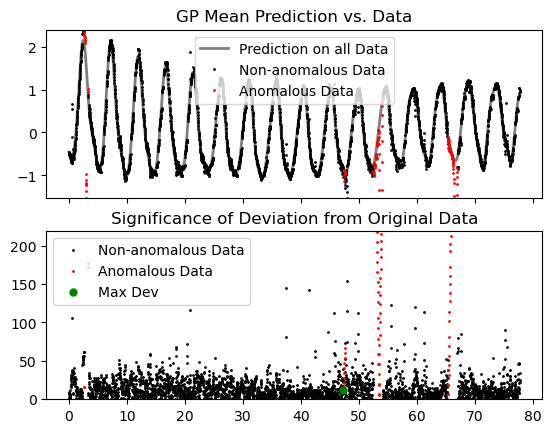



 New dip identified at anomalous index 2147, x[index] = 47.30208333333333
Old metric: 1000000.0 - New metric: 0.7239983081817627 = Diff metric: 999999.25
Anomaly index 4 x[i] 0.09375, left_edge:right_edge 2145:2149
Old metric: 0.7239983081817627 - New metric: 0.7238212823867798 = Diff metric: 0.00017702579498291016
Anomaly index 4 x[i] 0.09375, left_edge:right_edge 2143:2151
Old metric: 0.7238212823867798 - New metric: 0.7240808606147766 = Diff metric: -0.00025957822799682617
Anomaly index 4 x[i] 0.09375, left_edge:right_edge 2141:2153


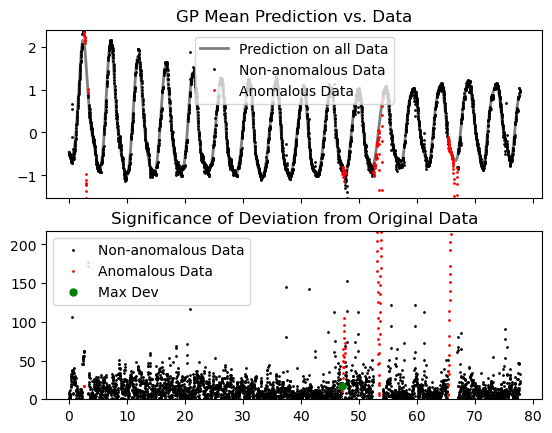



 New dip identified at anomalous index 2137, x[index] = 47.072916666666664
Old metric: 1000000.0 - New metric: 0.7244502902030945 = Diff metric: 999999.25
Anomaly index 5 x[i] 0.13541666666666666, left_edge:right_edge 2135:2139
Old metric: 0.7244502902030945 - New metric: 0.7247292399406433 = Diff metric: -0.0002789497375488281
Anomaly index 5 x[i] 0.13541666666666666, left_edge:right_edge 2133:2141


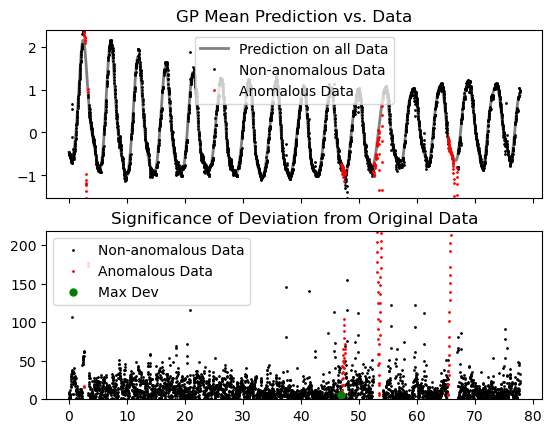



 New dip identified at anomalous index 2129, x[index] = 46.885416666666664
Old metric: 1000000.0 - New metric: 0.7240405678749084 = Diff metric: 999999.25
Anomaly index 6 x[i] 0.15625, left_edge:right_edge 2127:2131
Old metric: 0.7240405678749084 - New metric: 0.7243368625640869 = Diff metric: -0.0002962946891784668
Anomaly index 6 x[i] 0.15625, left_edge:right_edge 2125:2133


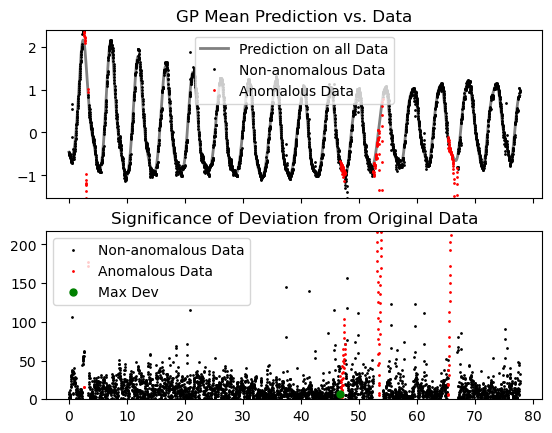



 New dip identified at anomalous index 2121, x[index] = 46.71875
Old metric: 1000000.0 - New metric: 0.7243802547454834 = Diff metric: 999999.25
Anomaly index 7 x[i] 0.17708333333333331, left_edge:right_edge 2119:2123
Old metric: 0.7243802547454834 - New metric: 0.7244952321052551 = Diff metric: -0.00011497735977172852
Anomaly index 7 x[i] 0.17708333333333331, left_edge:right_edge 2117:2125


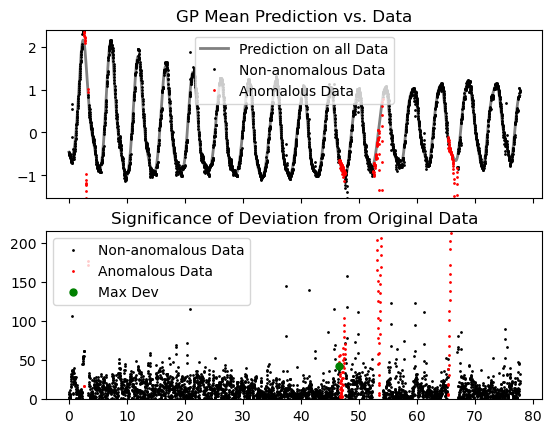



 New dip identified at anomalous index 2113, x[index] = 46.53125
Old metric: 1000000.0 - New metric: 0.7240250110626221 = Diff metric: 999999.25
Anomaly index 8 x[i] 0.19791666666666666, left_edge:right_edge 2111:2115
Old metric: 0.7240250110626221 - New metric: 0.7240966558456421 = Diff metric: -7.164478302001953e-05
Anomaly index 8 x[i] 0.19791666666666666, left_edge:right_edge 2109:2117


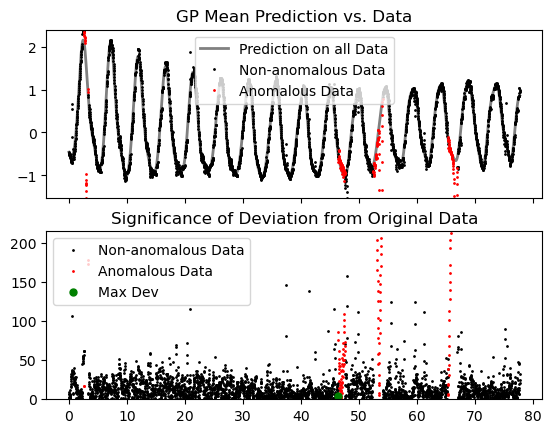

In [3]:
# Hyperparameters
which_metric = 'msll' # 'rmse', 'nlpd', msll, or default is 'mll'
num_anomalies = 9
num_steps = len(x)
anomalous = np.zeros(num_steps) # 0 means non-anomalous, 1 means anomalous at that time step
initial_lengthscale = None #0.3**2
expansion_param = 2 # how many indices left and right to increase anomaly by

# Train GP model
model, likelihood, mll = train_gp(x_tensor, y_tensor, y_err_tensor, training_iterations=30, lengthscale=initial_lengthscale, device=device)
final_lengthscale = model.covar_module.base_kernel.lengthscale.item()

# Step 7 (repeat for every anomaly)
for i in range(num_anomalies):
    # Get subset of data that is flagged an non-anomalous
    x_sub = torch.tensor(x[anomalous == 0], dtype=torch.float32).to(device)
    y_sub = torch.tensor(y[anomalous == 0], dtype=torch.float32).to(device)
    y_err_sub = torch.tensor(y_err[anomalous == 0], dtype=torch.float32).to(device)

    # Re-fit the GP on non-anomalous data
    model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

    # Predict
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_tensor))
        pred_mean = observed_pred.mean.cpu().numpy()
        pred_var = observed_pred.variance.cpu().numpy()

    # Find index of largest deviation
    sig_dev = (pred_mean - y) / y_err
    index = np.argmax(sig_dev[anomalous == 0])
    print(f"\n\n New dip identified at anomalous index {index}, x[index] = {x[index]}")

    # Intialize variables for expanding anomalous region
    left_edge = index
    right_edge = index
    diff_metric = 1e6
    metric = 1e6
    
    # While the metric is decreasing, expand the anomalous edges
    while diff_metric > 0:
        # Subset x, y, and y_err
        subset = (((np.arange(len(x)) > right_edge) | (np.arange(len(x)) < left_edge)) & (anomalous == 0))
        x_sub = torch.tensor(x[subset], dtype=torch.float32).to(device)
        y_sub = torch.tensor(y[subset], dtype=torch.float32).to(device)
        y_err_sub = torch.tensor(y_err[subset], dtype=torch.float32).to(device)
        
        # Re-fit the GP on non-anomalous data
        model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

        # Predict on subset
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(x_sub))
            pred_mean = observed_pred.mean.cpu().numpy()
            pred_var = observed_pred.variance.cpu().numpy()

        # Calculate metric difference
        old_metric = metric

        if which_metric == 'nlpd':
            metric = gpytorch.metrics.negative_log_predictive_density(observed_pred, y_sub)
        elif which_metric == 'msll':
            metric = gpytorch.metrics.mean_standardized_log_loss(observed_pred, y_sub)
        elif which_metric == 'rmse':
            metric = np.sqrt(np.mean((pred_mean - y_sub.cpu().numpy())**2))
        else: # metric == mll
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                output = model(x_sub)
                metric = mll(output, y_sub)

        diff_metric = old_metric - metric # smaller is better
        print(f"Old metric: {old_metric} - New metric: {metric} = Diff metric: {diff_metric}")

        # Expand anomalous region on both sides
        if left_edge >= 0 + expansion_param:
            left_edge -= expansion_param
        if right_edge < len(x) - expansion_param:
            right_edge += expansion_param

        print(f"Anomaly index {i} x[i] {x[i]}, left_edge:right_edge {left_edge}:{right_edge}")

    # Update anomalous array
    y[left_edge:right_edge] = pred_mean[left_edge:right_edge]
    anomalous[left_edge:right_edge] = 1

    # Predict on full dataset
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_tensor))
        pred_mean = observed_pred.mean.cpu().numpy()
        pred_var = observed_pred.variance.cpu().numpy()

    # Plot
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].set_title("GP Mean Prediction vs. Data")
    axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
    axs[0].plot(x[(anomalous==0)], y_orig[(anomalous==0)], '.k', markersize=2, label="Non-anomalous Data")
    axs[0].plot(x[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Anomalous Data")
    axs[0].set_ylim(np.min(y_sub.cpu().numpy()), np.max(y_sub.cpu().numpy()))
    axs[0].legend()

    sig_dev = (pred_mean - y) / y_err
    axs[1].set_title("Significance of Deviation from Original Data")
    axs[1].plot(x[(anomalous==0)], np.abs(sig_dev[(anomalous==0)]), '.k', markersize=2, label="Non-anomalous Data")
    axs[1].plot(x[(anomalous==1)], np.abs(sig_dev[(anomalous==1)]), '.r', markersize=2, label="Anomalous Data")
    axs[1].plot(x[np.argmax(sig_dev[(anomalous==0)])], np.abs(sig_dev[np.argmax(sig_dev[(anomalous==0)])]), '.g', markersize=10, label="Max Dev")
    axs[1].set_ylim(0, 20 * np.median(np.abs(sig_dev[(anomalous==0)])))
    axs[1].legend()
    plt.show(block=False)
    plt.pause(1)
    plt.close()

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


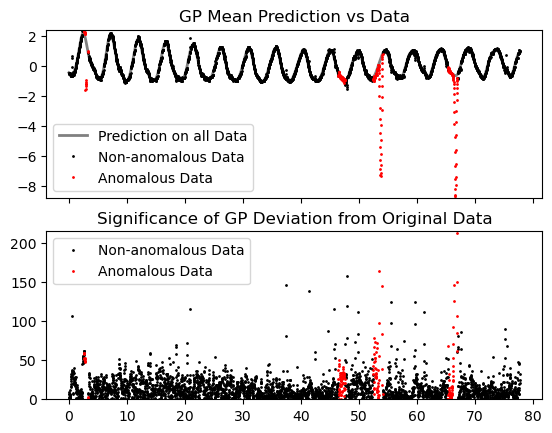

In [7]:
# Fit on final subset
model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_tensor))
    pred_mean = observed_pred.mean.cpu().numpy()
    pred_var = observed_pred.variance.cpu().numpy()

# Plot
fig, axs = plt.subplots(2,1,sharex=True)
axs[0].set_title("GP Mean Prediction vs Data")
axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
axs[0].plot(x_sub.cpu().numpy(), y_sub.cpu().numpy(), '.k', markersize=2, label="Non-anomalous Data")
axs[0].set_ylim(np.min(y_orig), np.max(y_orig))
axs[0].plot(x_orig[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Anomalous Data")
axs[0].legend()

sigdev = (pred_mean - y_orig) / y_err_orig
axs[1].set_title("Significance of GP Deviation from Original Data")
axs[1].plot(x[(anomalous==0)], np.abs(sigdev[(anomalous==0)]), '.k', markersize=2, label="Non-anomalous Data")
axs[1].plot(x[(anomalous==1)], np.abs(sigdev[(anomalous==1)]), '.r', markersize=2, label="Anomalous Data")
axs[1].set_ylim(0, 20 * np.median(np.abs(sigdev[(anomalous==0)])))
axs[1].legend()
plt.show(block=True)

In [8]:
# Check whether every anomaly_locs was identified in the anomalous array
identified = np.zeros(len(anomaly_locs))
flagged_anomalies = np.where(anomalous == 1)

for i in range(len(anomaly_locs)):
    anomaly = int(anomaly_locs[i])

    if np.isin(anomaly, flagged_anomalies):
        identified[i] = 1
    else:
        print(f"Anomaly at index {anomaly} was not identified in the anomalous array")

identified_ratio = np.sum(identified) / len(anomaly_locs)

print(f"Injected anomaly centers: {anomaly_locs}")
print(f"Anomalies identified: {identified}")
print(f"Ratio of anomalies identified: {identified_ratio}")
print(f"Flagged anomalies: {flagged_anomalies}")

Injected anomaly centers: [2987.920761291611, 2426.840741126586]
Anomalies identified: [1. 1.]
Ratio of anomalies identified: 1.0
Flagged anomalies: (array([ 122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141, 2109, 2110,
       2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121,
       2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132,
       2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143,
       2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154,
       2155, 2156, 2157, 2158, 2371, 2372, 2373, 2374, 2375, 2376, 2377,
       2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388,
       2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399,
       2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410,
       2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421,
       2422, 2423, 2424, 2425, 2426, 2427, 2428